In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_long_from_analysis,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave,plot_single_plate
import matplotlib.patches as mpatches
import statsmodels.api as sm
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
import scipy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.io as sio
import matplotlib as mpl
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.legend_handler import HandlerTuple
from amftrack.util.plot import gridplot
import logging
from datetime import timedelta

%store -r path_figure

logging.getLogger().setLevel(logging.WARNING)
plt.style.use('presentation.mplstyle')

%matplotlib widget

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
all_analysis_folders = get_analysis_folders()
plates = [
"440_20230723",
"447_20230821",
"481_20231005",
"482_20230908",
]
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]
folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,use_saved=False)
time_plate_info = time_plate_info.replace(-1.0,np.nan)
width = 1.6
height = 1
# folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders,use_saved=False)
# folders,global_hypha_info = get_global_hypha_info_from_analysis(analysis_folders,use_saved=False)

In [ ]:
path_figure = r'C:\\Users\\coren\\AMOLF-SHIMIZU Dropbox\\HFSP_symbiotic-networks\\Article_TravellingWave\\Supplementary material\\extended_data_figures'

2024-05-16 14:31:13,227-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


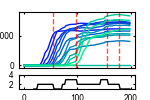

In [7]:
from scipy.signal import savgol_filter
width = 1.5
height = 1

# Assuming 'plates', 'time_plate_info', and 'j' are defined elsewhere in your code

cmap2 = mpl.cm.get_cmap("winter")
maxi = 15
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True,height_ratios=[0.8,0.2],figsize = (width,height))
j=0
plate = plates[j]
table = time_plate_info.loc[time_plate_info["unique_id"] == int(plate)].copy()
table["num_connected_roll"] = table["num connected"].rolling(3).max().fillna(0)
table = table.set_index('timestep', drop=False)
table = table[table["time_since_begin"] / pd.Timedelta(hours=1) <= 200]
table = table.sort_values('time_since_begin')

# Calculate the derivative of num_connected_roll
time_hours = table["time_since_begin"] / pd.Timedelta(hours=1)
num_connected_roll = table["num_connected_roll"].values
num_connected_roll_derivative = np.diff(num_connected_roll)

# Plot the data
window_size = 11  # Adjust to your dataset
poly_order = 1

for index in range(1, maxi):
    column = f"ring_density_incr-100_index-{index}"
    table[column] = table[column].fillna(0)
    smoothed_values = savgol_filter(table[column], window_size, poly_order)
    ax.plot(
        time_hours,
        smoothed_values,
        color=cmap2(index/maxi),
    )

ax2.plot(
    time_hours,
    num_connected_roll,
    color="black"
)

# Identify where derivative is negative and plot vertical lines on ax
negative_derivative_indices = np.where(num_connected_roll_derivative < 0)[0]
for idx in negative_derivative_indices:
    ax.axvline(x=time_hours.iloc[idx], color='red', linestyle='--', alpha=0.7)

# Adjust labels and titles as necessary
ax2.set_xlabel("time since begin (hours)")
ax.set_ylabel('filament density \n($\mu m$ $mm^{-2}$)')  # Adjust labelpad as needed
ax2.set_ylabel("$N_{CC}$", labelpad=15)  # Adjust labelpad as needed
ax2.set_ylim(1,4)
plt.savefig(os.path.join(path_figure,f'Figure_rebutal_collide_{plate}.pdf'), transparent=True, bbox_inches='tight')

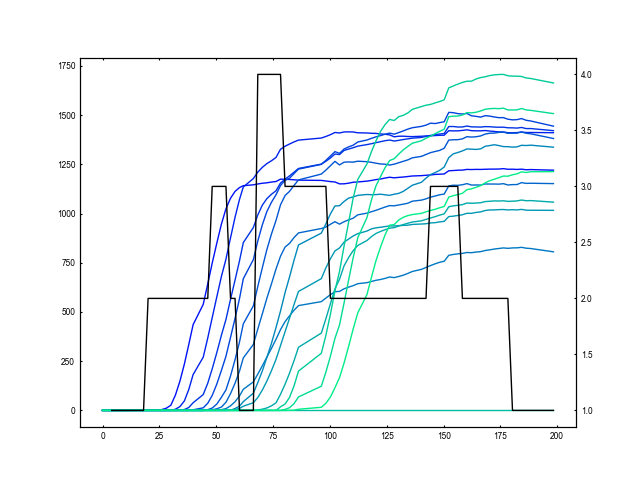

In [31]:
from scipy.signal import savgol_filter

# Your existing setup
cmap2 = mpl.cm.get_cmap("winter")
maxi = 15
fig, ax = plt.subplots()
ax2 = ax.twinx()

plate = plates[j]
table = time_plate_info.loc[time_plate_info["unique_id"] == int(plate)].copy()
table["num_connected_roll"]=table["num connected"].rolling(3).max()
# table_err = time_plate_info_long.loc[time_plate_info_long["Plate"]==plate]
table = table.set_index('timestep',drop=False)
table = table[table[f"time_since_begin"]/pd.Timedelta(hours=1)<=200]
table = table.sort_values('time_since_begin')
# Define the window size and polynomial order for the filter
window_size = 11  # window size: must be odd, adjust to your dataset
poly_order = 1  # polynomial order: degree of the polynomial

for index in range(1, maxi):
    column = f"ring_density_incr-100_index-{index}"
    # Apply Savitzky-Golay filter
    table[column] = table[column].fillna(0) 
    smoothed_values = savgol_filter(table[column], window_size, poly_order)
    ax.plot(
        table[f"time_since_begin"]/pd.Timedelta(hours=1),
        smoothed_values,
        color=cmap2(index/maxi),
    )
ax2.plot(
    table[f"time_since_begin"]/pd.Timedelta(hours=1),
        table["num_connected_roll"],color="black")

In [36]:
num_connected_roll

array([0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 2., 2., 1., 1., 1., 4., 4.,
       4., 4., 4., 4., 3., 3., 3., 3., 3., 3., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3.,
       3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

In [35]:
num_connected_roll_derivative

array([ 0.00000000e+00,  2.47933884e-01,  2.46905113e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.77555756e-17,  0.00000000e+00,
        0.00000000e+00,  2.50000000e-01,  2.50000000e-01, -1.11022302e-16,
        0.00000000e+00, -5.55111512e-17,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.11022302e-16, -1.11022302e-16,  1.11022302e-16,
       -2.77555756e-17,  0.00000000e+00,  2.59655956e-01,  2.60719672e-01,
       -1.11022302e-16,  0.00000000e+00, -2.50000000e-01, -2.50000000e-01,
       -2.59655956e-01, -2.37591155e-01, -2.08166817e-17,  1.06725735e+00,
        7.78967868e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -2.48953975e-01, -2.46835443e-01, -1.11022302e-16,
        1.11022302e-16, -2.08166817e-17,  2.22044605e-16, -2.50000000e-01,
       -2.50000000e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.11022302e-16,  0.00000000e+00,
        0.00000000e+00,  